# Анализ данных в задаче кредитного скоринга

Используется датасет с данными о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:
- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

Проверим следующие гипотезы для платящих вовремя (default=0) и должников (default=1):
* равенство медианных значений кредитного лимита
* равенство распределений
* влияние гендерного состава
* влияние образования
* влияние семейного положения
* влияние возраста

В этой небольшой работе я не ставлю перед собой цели исчерпывающе ответить на вопросы, возникающие при кредитном анализе. Здесь я хочу продемонстрировать, как работают статистические критерии, а также показать разницу между статистической и практической значимостью

In [67]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [7]:
# Проверим на наличин NaN
data.isna().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

### Гипотеза о равенстве медианных значений кредитного лимита

default
0    23364
1     6636
dtype: int64


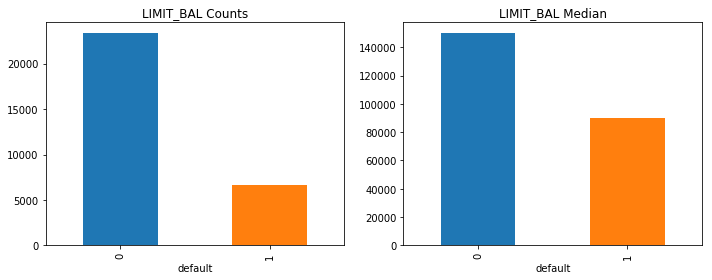

In [8]:
# Визуально сравним количество и медианы LIMIT_BAL в зависимости от default
df_grouped = data.groupby('default')
print(df_grouped.size())

fig, axes = plt.subplots(1,2, figsize=(10,4))
df_grouped['LIMIT_BAL'].size().plot(kind='bar', ax=axes[0])
df_grouped['LIMIT_BAL'].apply(np.median).plot(kind='bar', ax=axes[1])
axes[0].set_title('LIMIT_BAL Counts')
axes[1].set_title('LIMIT_BAL Median')
plt.tight_layout();

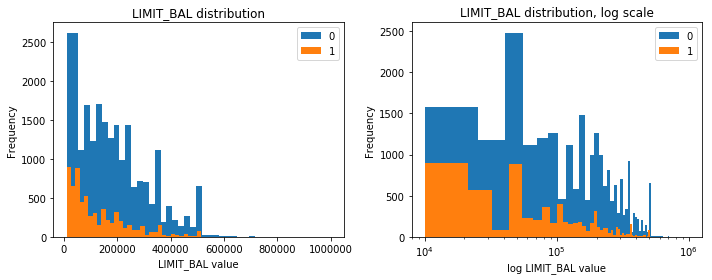

In [9]:
# Построим распределения LIMIT_BAL в зависимости от default
fig, axes = plt.subplots(1,2, figsize=(10,4))
df_grouped['LIMIT_BAL'].plot(kind='hist', bins=45, legend=True, ax=axes[0])
df_grouped['LIMIT_BAL'].plot(kind='hist', bins=65, legend=True, logx=True, ax=axes[1])
axes[0].set_title('LIMIT_BAL distribution')
axes[0].set_xlabel('LIMIT_BAL value')
axes[1].set_title('LIMIT_BAL distribution, log scale')
axes[1].set_xlabel('log LIMIT_BAL value')
plt.tight_layout();

Гистограммы показывают, что распределения LIMIT_BAL для для вернувших и не вернувших кредиты не подчиняются нормальному. Следовательно, нужно использовать непараметрические критерии для проверки равентсва точечных оценок и проверки однородности.


Для проверки гипотезы о равенстве медианных значений используем bootstrap

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [20]:
# Интервальная оценка медианы
def_0 = data[data.default==0].LIMIT_BAL.values
def_1 = data[data.default==1].LIMIT_BAL.values

np.random.seed(0)

def_0_med = list(map(np.median, get_bootstrap_samples(def_0, 1000)))
def_1_med = list(map(np.median, get_bootstrap_samples(def_1, 1000)))
delta_med = list(map(lambda x: x[0] - x[1], zip(def_0_med, def_1_med)))

print ('95% confidence interval for the default=0: {}'.format(stat_intervals(def_0_med, 0.05)))
print ('95% confidence interval for the default=1: {}'.format(stat_intervals(def_1_med, 0.05)))
print ('95% confidence interval for delta median:  {}'.format(stat_intervals(delta_med, 0.05)))

95% confidence interval for the default=0: [ 150000.  150000.]
95% confidence interval for the default=1: [ 80000.  90000.]
95% confidence interval for delta median:  [ 60000.  70000.]


**Вывод 1.** Доверительные интервалы для разности медиан не содержат 0, значит, гипотезу о равенстве медиан отвергаем

### Гипотеза о равенстве распределений

Для проверки этой гипотезы воспользуемся перестановочным критерием:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [21]:
# t-статистика
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [26]:
# Генерация случайных индексов для разбиения выборок
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [27]:
# Нулевое распределение
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [28]:
# Перестановочный критерий
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [29]:
print ('p-value: {}%'.format(permutation_test(def_0, def_1, max_permutations = 2000)))

p-value: 0.0005%


**Вывод 2:** p-value значительно меньше уровня значимости 0.05, поэтому нулевую гипотезу о равенстве распределений LIMIT_BAL для групп default = 1 и 2 отвергаем

### Влияние гендерного состава

default  SEX
0        1       9015
         2      14349
1        1       2873
         2       3763
dtype: int64


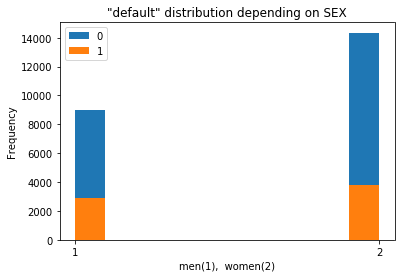

In [31]:
# Распределение default по полу
print (data.groupby(['default', 'SEX']).size())

ax = df_grouped['SEX'].plot(kind='hist', title=('"default" distribution depending on SEX'), legend=True, xticks=(1,2))
ax=ax[0]
ax.set_xlabel('men(1),  women(2)');

Мы должны проверить две гипотезы:

$H_0\colon p_1 = p_2$ - доли равны

$H_1\colon p_1 \ne p_2$ - доли не равны

Наши выборки удовлетворяют условию $n\hat{p}>5$ и $n(1-\hat{p})>5$, поэтому для проверки гипотезы можно пользоваться z-критерием для независимых выборок:
$$Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

Интервальную оценку достоверности гипотезы проверим, построив доверительный интервал для $p_1 - p_2$:
$$\hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}},$$
(в нашем случае доли НЕ близки к 0 или 1 и построение доверительного интервала Уилсона не требуется)

In [32]:
# Убедимся в отсутствии необходимости применения доверительного интервала Уилсона (главная диагональ таблцы)
df_grouped['SEX'].value_counts().apply(lambda x: x/df_grouped['SEX'].size())

default             0         1
default SEX                    
0       2    0.614150  2.162297
        1    0.385850  1.358499
1       2    0.161060  0.567058
        1    0.122967  0.432942

In [33]:
import scipy
from statsmodels.stats.proportion import proportion_confint

In [34]:
# доверительный интервал разности долей
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [35]:
# z-статистика
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [36]:
# z-критерий
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [37]:
men = data[data.SEX==1].default.values
women = data[data.SEX==2].default.values

In [38]:
z_stat = proportions_diff_z_stat_ind(men, women)

In [42]:
print ('p-value = {}'.format(proportions_diff_z_test(z_stat, alternative = 'two-sided')))
print ('95% доверительный интервал разности долей: {}'.
       format(np.round(proportions_diff_confint_ind(men, women, alpha = 0.05),3)))

p-value = 4.472866521609831e-12
95% доверительный интервал разности долей: [ 0.024  0.044]


**Вывод 3:** оба критерия показывают, что гендерный состав групп людей, вернувших и не вернувших кредит, *отличается*

## Влияние образования

Проверять эту гипотезу будем с помощью критерия $\chi^2$:
$$\chi^2=\sum \frac{(obs-exp)^2}{exp}$$
Как покажут дальнейшие выкладки, условия его использования выполнены: все ожидаемые числа больше 1 и доля клеток с ожидаемыми числами <5 не превышает 20%.

В демонстрационных целях построим несколько таблиц сопряжённости и покажем, как строится данный критерий:
запишем в каждую ячейку соответствующее слагаемое, и чем больше оно будет, тем больший вклад оно вносит во всю сумму, и, тем самым, в опровержение нулевой гипотезы.

In [43]:
# Построим таблицу сопряжённости "Education-Default" НАБЛЮДАЕМЫХ значений
df_cross_obs = pd.crosstab(data.default, data.EDUCATION, margins=True)
df_cross_obs

EDUCATION,0,1,2,3,4,5,6,All
default,,,,,,,,
0,14,8549,10700,3680,116,262,43,23364
1,0,2036,3330,1237,7,18,8,6636
All,14,10585,14030,4917,123,280,51,30000


In [44]:
# Построим таблицу сопряжённости "Education-Default" ОЖИДАЕМЫХ значений
# Для этого используем функцию chi2_contingency() класса stats библиотеки scipy
col_label = list(range(0,7))+['All']
row_label = list(range(0,2))+['All']

expect_values = scipy.stats.chi2_contingency(df_cross_obs, correction=False)[3]
df_cross_expect = pd.DataFrame(expect_values, index=row_label, columns=col_label)
df_cross_expect.rename_axis('EDUCATION', axis='columns', inplace=True)
df_cross_expect.rename_axis('default', axis='index', inplace=True)
df_cross_expect

EDUCATION,0,1,2,3,4,5,6,All
default,,,,,,,,
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188,23364.0
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812,6636.0
All,14.0000,10585.000,14030.000,4917.0000,123.0000,280.000,51.0000,30000.0


In [51]:
# Построим таблицу сопряжённости "Education-Default" для РАЗНОСТИ наблюдаемых и ожидаемых значений
df_cross_sub = df_cross_obs.sub(df_cross_expect)

# Нормируем как предполагает критерий
df_cross_sub_norm = df_cross_sub.apply(lambda x: x**2).div(df_cross_expect)

Наглядно продемонстрируем разницу в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг

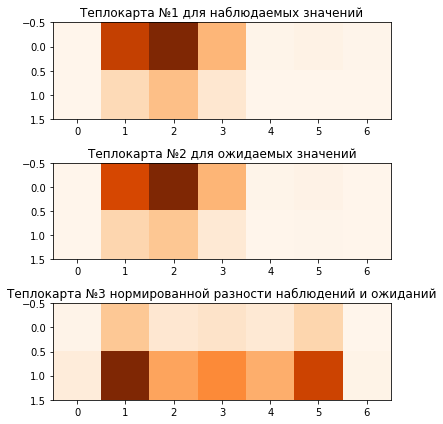

In [52]:
# Построим теплокарты (heatmaps) всех таблиц сопряжённости
fig, ax = plt.subplots(3,1, figsize=(11,6))
ax[0].imshow(df_cross_obs.iloc[:2,:7], cmap='Oranges')
ax[0].set_title(u'Теплокарта №1 для наблюдаемых значений')

ax[1].imshow(df_cross_expect.iloc[:2,:7], cmap='Oranges')
ax[1].set_title(u'Теплокарта №2 для ожидаемых значений')

ax[2].imshow(df_cross_sub_norm.iloc[:2,:7], cmap='Oranges')
ax[2].set_title(u'Теплокарта №3 нормированной разности наблюдений и ожиданий')

plt.tight_layout();

Heatmap №1 показывает, что бОльшая часть не вернувших кредит принадлежит группам с education=1, 2 и 3. Надо отметить, что и заёмщиков из групп с education=1, 2 и 3 больше.

Heatmap нормированной разности наблюдений и ожиданий (слагаемые $\chi^2$) показывает группы с наибольшим вкладом в опровержение нулевой гипотезы об отсутствии связи между образованием и возвратом/не возвратом долга.

In [53]:
# Мы уже посчитали критерий, когда использовали scipy.stats.chi2_contingency
# Осталось вызвать результат:
chi2, p_value = scipy.stats.chi2_contingency(df_cross_obs, correction=False)[0:2]
print ('chi2 = {}\np_value = {}'.format(chi2, p_value))

chi2 = 163.2165578699707
p_value = 1.5987086709565762e-27


p_value очень мало, поэтому нулевую гипотезу отвергаем

In [55]:
# chi2 можно получить и по-другому, просто сложив все ячейки df_cross_sub_norm
chi2_crosstab = df_cross_sub_norm.values[0:2].sum()
print ('chi2_crosstab = {}'.format(chi2_crosstab))

chi2_crosstab = 163.2165578699707


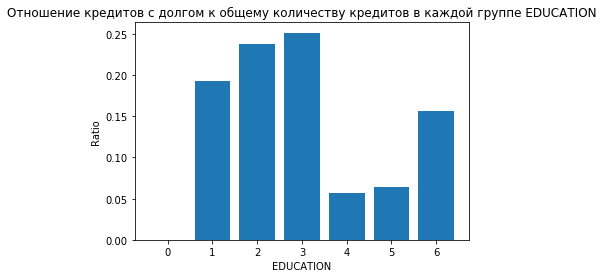

In [56]:
# Посмотрим на отношения "default=1 / default=0" в каждой группе EDUCATION
# Нормируем таблицу сопряжённости наблюдаемых значений по каждому столбцу
df_cross_obs_norm = pd.crosstab(data.default, data.EDUCATION, normalize='columns')

plt.figure()
x = list(range(0,7))
y = df_cross_obs_norm.values[1]
plt.bar(x,y)
plt.xlabel('EDUCATION')
plt.ylabel('Ratio')
plt.title(u'Отношение кредитов с долгом к общему количеству кредитов в каждой группе EDUCATION');

Видим, что группа education=0 (доктора наук) вообще не имеет должников. Самая высокая доля неплательщиков у education=3 - выпускников школы.

**Выводы 4:**
- образование *влияет* на вероятность возврата кредита;
- заёмщики из группы докторов наук *вернут* кредит с большей вероятностью, чем заёмщики из других групп;
- заёмщики из группы выпускников школ *не вернут* кредит с большей вероятностью, чем заёмщики из других групп.

## Влияние семейного положения

default  MARRIAGE
0        0              49
         1           10453
         2           12623
         3             239
1        0               5
         1            3206
         2            3341
         3              84
dtype: int64


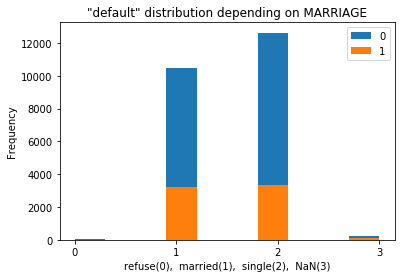

In [58]:
# Распределение default по семейному положению
print (data.groupby(['default', 'MARRIAGE']).size())

ax = df_grouped['MARRIAGE'].plot(kind='hist', title=('"default" distribution depending on MARRIAGE')\
                                 ,legend=True, xticks=np.arange(0,4))
ax=ax[0]
ax.set_xlabel('refuse(0),  married(1),  single(2),  NaN(3)');

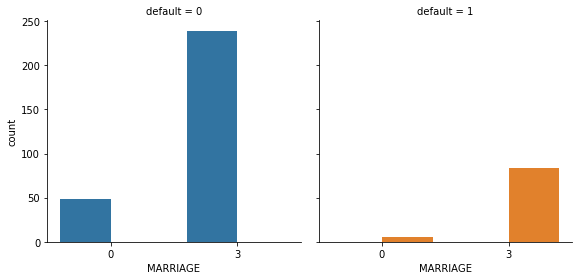

In [59]:
# Посмотрим отдельно на группы 0 и 3
import seaborn as sns
sns.catplot('MARRIAGE', col="default", hue='default', data=data[(data.MARRIAGE == 0) | (data.MARRIAGE == 3)]\
            ,kind='count', height=4);

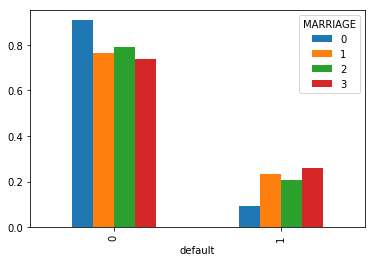

In [60]:
pd.crosstab(data.default, data.MARRIAGE, normalize='columns').plot.bar();

На графиках видим, что наименьшая доля просроченых кредитов у группы MARRIAGE=0. Доля просрочек у остальных категорий примерно одинакова

Для **количественной** оценки связи семейного статуса с индикатором дефолта воспользуемся v-критерием Крамера, т.к. наши признаки категориальные

In [61]:
# Функция для вычисления v-критерия Крамера
def v_cramer(chi2, n, dof_min):
    return np.sqrt(chi2 / (n*(dof_min - 1)))

In [62]:
# Параметры для вычисления v-критерия Крамера
chi2, p_value = scipy.stats.chi2_contingency(pd.crosstab(data.default, data.MARRIAGE), correction=False)[0:2]
n = pd.crosstab(data.default, data.MARRIAGE).values.flatten().sum()
dof_min = np.min(pd.crosstab(data.default, data.MARRIAGE).shape)

In [66]:
print ('v_cramer = {}'.format(v_cramer(chi2, n, dof_min)))

v_cramer = 0.034478203662766466


**Вывод 5:** Коэффициент корреляции Крамера достаточно мал, что говорит об отсутствии взаимосвязи

## Влияние возраста

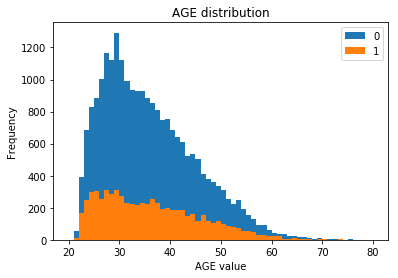

In [68]:
# Визуально сравним распределения
df_grouped['AGE'].plot(kind='hist', bins=60, legend=True, range=(20, 80))
plt.title('AGE distribution')
plt.xlabel('AGE value');

In [69]:
# Интервальная оценка медианы
def_0 = data[data.default==0].AGE.values
def_1 = data[data.default==1].AGE.values

np.random.seed(0)

def_0_med = list(map(np.median, get_bootstrap_samples(def_0, 1000)))
def_1_med = list(map(np.median, get_bootstrap_samples(def_1, 1000)))
delta_med = list(map(lambda x: x[0] - x[1], zip(def_0_med, def_1_med)))

print ('95% confidence interval for the default=0: {}'.format(stat_intervals(def_0_med, 0.05)))
print ('95% confidence interval for the default=1: {}'.format(stat_intervals(def_1_med, 0.05)))
print ('95% confidence interval for delta median:  {}'.format(stat_intervals(delta_med, 0.05)))

95% confidence interval for the default=0: [ 34.  34.]
95% confidence interval for the default=1: [ 34.  35.]
95% confidence interval for delta median:  [-1.  0.]


0 входит в доверительный интервал, но приэтом является его границей. Поэтому нужно провести дополнительную проверку перестановочным критерием 

In [70]:
print ('p-value: {}%'.format(permutation_test(def_0, def_1, max_permutations = 2000)))

p-value: 0.0145%


**Вывод 6:** p-value меньше уровеня значимости 0.05, поэтому нулевую гипотезу о равенстве распределений мы должны отвергнуть. Однако, если построить описательную статистику (ниже), то можно увидеть, что все точечные характеристики рапределения default в зависимости от возраста равны или практически равны. Это наталкивает на мысль, что с практической точки зрения возраст как признак можно исключить из модели для предсказания риска невозврата кредита.

In [406]:
df_grouped['AGE'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,23364.0,35.417266,9.077355,21.0,28.0,34.0,41.0,79.0
1,6636.0,35.725738,9.693438,21.0,28.0,34.0,42.0,75.0
